In [4]:
# Remove warnings
import warnings

warnings.filterwarnings('ignore')

# Data manipulation 
import pandas as pd
# Dates handling
from datetime import datetime, timedelta
import pytz
from dateutil.relativedelta import relativedelta
# Chart modules
import matplotlib.pyplot as plt
import seaborn as sns

# Linear algrebra
import numpy as np


# Technical indicators
from scipy.signal import savgol_filter, convolve, lfilter
from ta.trend import ema_indicator, trix, dpo

from modules.Utils.utils import loadFromDB, computeFutureLinearRegression, strategyTester
from modules.Utils.indicators import computeLaggingLinearRegression, computeTrixIndicator, addIndicators, computeRSI_VWAP, computeMASlope


from statsmodels.tsa.filters.hp_filter import hpfilter

def filterData(data, method='savgol')->np.array:
    """function the filter a signal with a specific method.

    Args:
        data (np.array): The input signal to denoise.
        method (str): The filtering/denoising method. Default to 'savgol'.

    Returns:
        np.array: The filtered signal.
    """
    if method=='savgol':
        return savgol_filter(data, 30, 2, mode='nearest')
    elif method=='hpf':
        cycle, trend = hpfilter(data,120)
        return trend

In [7]:
SYMBOL= 'BTC'
df = loadFromDB(f'../backtest_tools/database/database/KuCoin/1h/{SYMBOL}-USDT.csv')
df["EMA20"] = ema_indicator(df["Close"], 20)
df.dropna(inplace=True)
print(df.shape)
df.head()

(21784, 7)


,Open,High,Low,Close,Volume,Timestamp,EMA20
Date,,,,,,,
2020-01-01 20:00:00,7240.1,7240.1,7224.9,7229.0,13.119735,1577905200,7217.651537
2020-01-01 21:00:00,7229.0,7240.0,7227.0,7236.9,15.305158,1577908800,7219.484724
2020-01-01 22:00:00,7236.8,7239.4,7226.6,7234.2,16.852126,1577912400,7220.886179
2020-01-01 23:00:00,7234.1,7234.1,7190.0,7198.0,38.299173,1577916000,7218.706543
2020-01-02 00:00:00,7198.0,7202.3,7180.0,7200.2,18.005546,1577919600,7216.944015


In [37]:
from tsmoothie.regression_basis import cubic_spline
from tsmoothie.smoother import ConvolutionSmoother, LowessSmoother, KalmanSmoother, PolynomialSmoother, ExponentialSmoother, WindowWrapper

# operate smoothing
#smoother = LowessSmoother(smooth_fraction=0.01, iterations=2)
smoother = ConvolutionSmoother(50,'bartlett')
#smoother = ExponentialSmoother(1, 0.3)

smoother.smooth(df.EMA20.values.reshape(1, -1))
 
df['EMA20_denoised'] =filterData(df.EMA20.values,'hpf')#savgol_filter(df.EMA20.values, 30, 2, mode='nearest')
df['EMA20_diff'] = df.EMA20_denoised.diff(1)#.diff(1)
df.dropna(inplace=True)
df

,Open,High,Low,Close,Volume,Timestamp,EMA20,EMA20_denoised,EMA20_diff
Date,,,,,,,,,
2021-07-12 01:00:00,2.1734,2.1734,2.1734,2.1734,0.000000,1626044400,2.172957,2.173285,-0.000181
2021-07-12 02:00:00,2.1699,2.1699,2.1699,2.1699,5.951900,1626048000,2.172666,2.172744,-0.000174
2021-07-12 03:00:00,2.1692,2.1692,2.1692,2.1692,13.659200,1626051600,2.172336,2.172041,-0.000163
2021-07-12 04:00:00,2.1795,2.2270,2.1795,2.2190,64.106400,1626055200,2.176780,2.171185,-0.000153
2021-07-12 05:00:00,2.2318,2.2318,2.2176,2.2198,105.518600,1626058800,2.180877,2.170171,-0.000157
...,...,...,...,...,...,...,...,...,...
2022-08-24 17:00:00,4.2630,4.3930,4.2621,4.3775,81491.813045,1661353200,4.249629,4.237592,-0.000125
2022-08-24 18:00:00,4.3795,4.4026,4.3437,4.3610,85031.754693,1661356800,4.260236,4.238346,-0.000139
2022-08-24 19:00:00,4.3606,4.3671,4.3251,4.3316,38678.189081,1661360400,4.267033,4.238938,-0.000161


In [43]:
X = df.EMA20.iloc[:-1].values
y = df.EMA20.iloc[1:].values
X,y

(array([2.17295727, 2.1726661 , 2.172336  , ..., 4.26023615, 4.2670327 ,
        4.27400102]),
 array([2.1726661 , 2.172336  , 2.17678019, ..., 4.2670327 , 4.27400102,
        4.28389616]))

In [49]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X.reshape(-1, 1),y)
lr.score(X.reshape(-1, 1),y)

0.9999392936727756

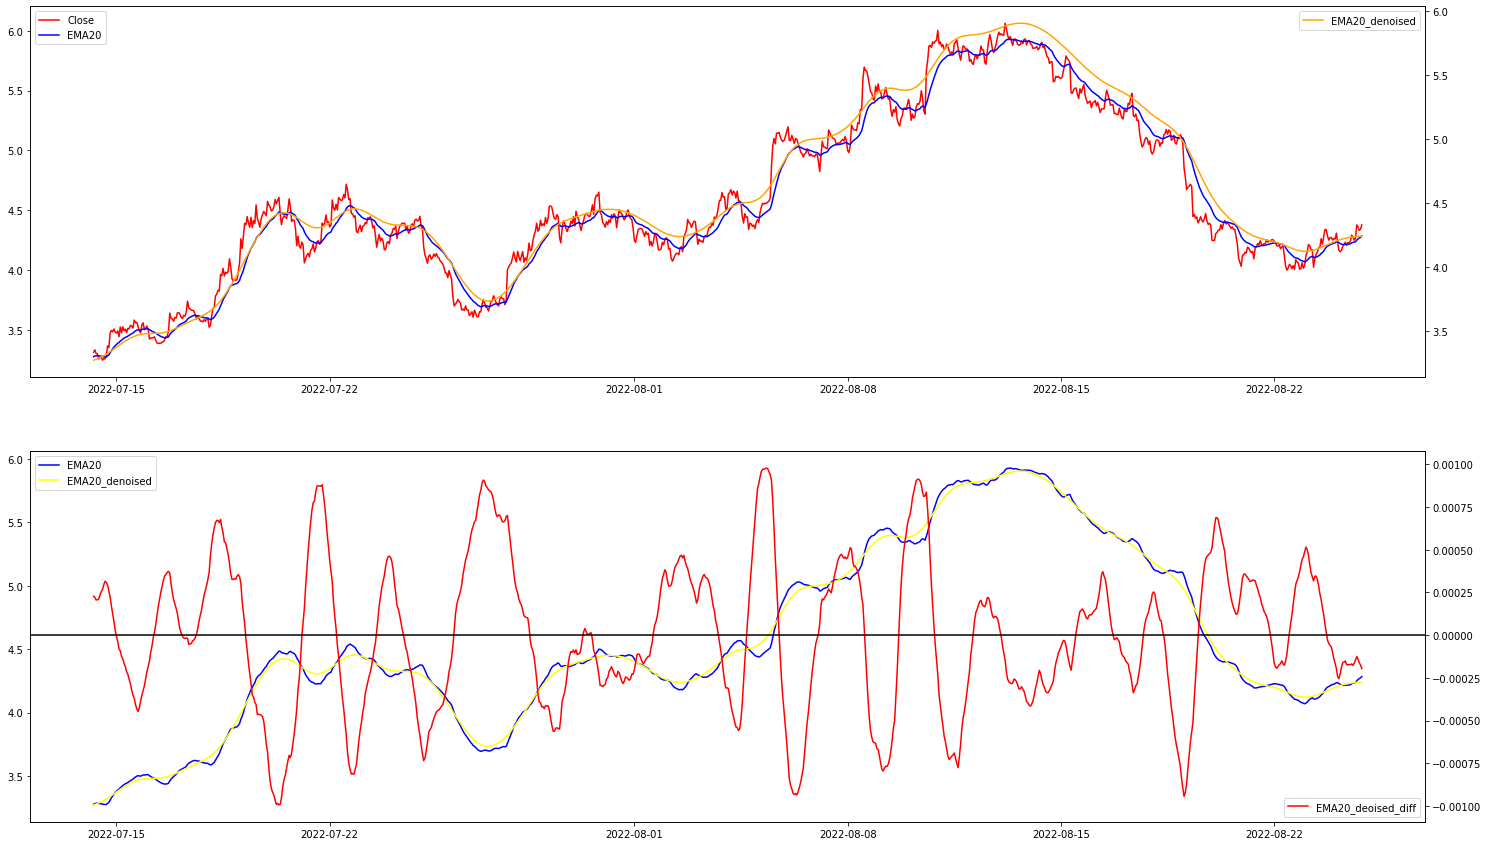

In [38]:
fig, ax_left = plt.subplots(2, figsize=(25,15))
ax_right =[]

ind=1000

ax_right.append(ax_left[0].twinx())
ax_right.append(ax_left[1].twinx())

ax_left[0].plot(df.Close[-ind:], color='red',label='Close')
ax_left[0].plot(df.EMA20[-ind:], color='blue',label='EMA20')
ax_right[0].plot(df.EMA20_denoised[-ind:], color='orange',label='EMA20_denoised')
ax_left[0].legend(loc="upper left")
#ax_right[0].plot(df.EMA20_diff[-ind:], color='orange',label='EMA20_deoised_diff')
#ax_right[0].axhline(y=0, color='black')
ax_right[0].legend(loc="upper right")

ax_left[1].plot(df.EMA20[-ind:], color='blue',label='EMA20')
ax_left[1].plot(df.EMA20_denoised[-ind:], color='yellow',label='EMA20_denoised')
ax_right[1].plot(df.EMA20_diff[-ind:], color='red',label='EMA20_deoised_diff')
ax_right[1].axhline(y=0, color='black')
ax_left[1].legend(loc="upper left")
ax_right[1].legend(loc="lower right")
#sns.histplot(data=df['B_MLR_coefs'], ax = ax_leRSIft[1])

Period : [2021-07-12 01:00:00] -> [2022-08-24 21:00:00]
Starting balance : 1000 $

----- General Informations -----
Final balance : 39452103.4 $
Performance vs US Dollar : 3945110.34 %
Buy and Hold Performence : 101.43 %
Performance vs Buy and Hold : 3889354.67 %
Best trade : +71.56 %, the 2021-09-08 16:00:00
Worst trade : -7.96 %, the 2022-01-23 11:00:00
Worst drawBack : -14.000000000000002 %
Total fees :  1051212.6 $

----- Trades Informations -----
Total trades on period : 163
Number of positive trades : 140
Number of negative trades :  23
Trades win rate ratio : 85.89 %
Average trades performance : 7.17 %
Average positive trades : 8.71 %
Average negative trades : -2.18 %

----- Plot -----


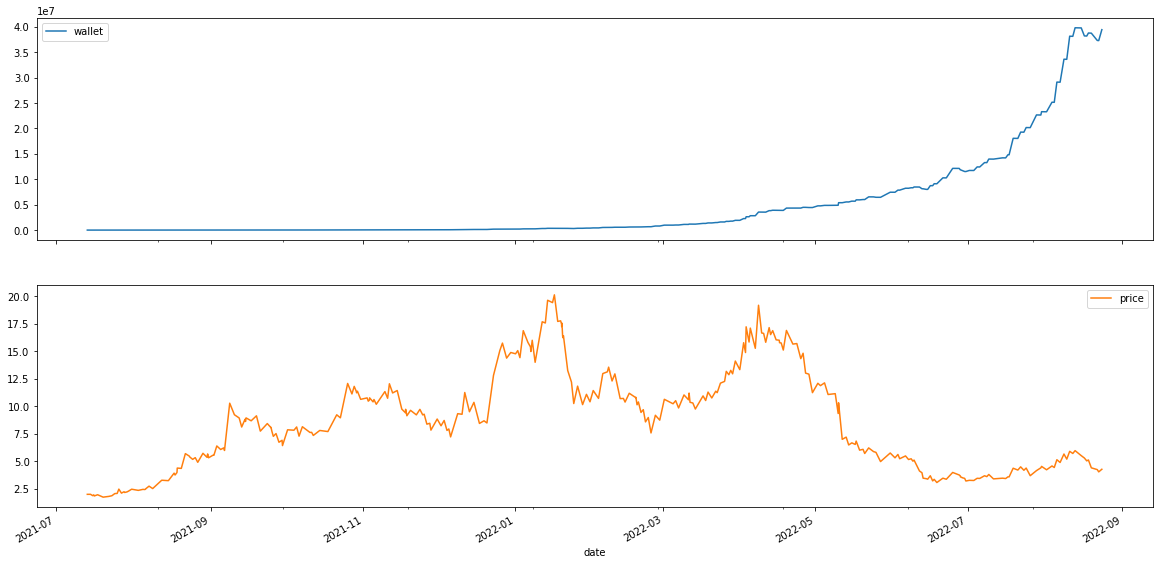

In [39]:
def buyCondition(row:pd.Series, previous_row:pd.Series=None)->bool:
    return True if row.EMA20_diff>0 else False

def sellCondition(row:pd.Series, previous_row:pd.Series=None)->bool:
    return True if row.EMA20_diff<0 else False

strategyTester(df,buyCondition,sellCondition,equity=1000)

# New calculation (inloop filtering)

In [19]:
SYMBOL= 'BTC'
df = loadFromDB(f'../backtest_tools/database/database/KuCoin/1h/{SYMBOL}-USDT.csv')
df["EMA20"] = ema_indicator(df["Close"], 20)
df.dropna(inplace=True)
df['EMA20_denoised'] =filterData(df.EMA20.values,'hpf')
#savgol_filter(df.EMA20.values, 30, 2, mode='nearest')
df['EMA20_diff'] = df.EMA20_denoised.diff(1)
print(df.shape)
df.head()

(21784, 9)


,Open,High,Low,Close,Volume,Timestamp,EMA20,EMA20_denoised,EMA20_diff
Date,,,,,,,,,
2020-01-01 20:00:00,7240.1,7240.1,7224.9,7229.0,13.119735,1577905200,7217.651537,7224.161809,NaN
2020-01-01 21:00:00,7229.0,7240.0,7227.0,7236.9,15.305158,1577908800,7219.484724,7221.964799,-2.197010
2020-01-01 22:00:00,7236.8,7239.4,7226.6,7234.2,16.852126,1577912400,7220.886179,7219.713536,-2.251262
2020-01-01 23:00:00,7234.1,7234.1,7190.0,7198.0,38.299173,1577916000,7218.706543,7217.333102,-2.380434
2020-01-02 00:00:00,7198.0,7202.3,7180.0,7200.2,18.005546,1577919600,7216.944015,7214.758349,-2.574753


Period : [2020-01-01 20:00:00] -> [2022-08-29 00:00:00]
Starting balance : 1000 $

----- General Informations -----
Final balance : 121629210.99 $
Performance vs US Dollar : 12162821.1 %
Buy and Hold Performence : 175.21 %
Performance vs Buy and Hold : 6941660.58 %
Best trade : +29.49 %, the 2020-04-30 15:00:00
Worst trade : -4.78 %, the 2021-01-12 14:00:00
Worst drawBack : -5.0 %
Total fees :  6133915.67 $

----- Trades Informations -----
Total trades on period : 367
Number of positive trades : 313
Number of negative trades :  54
Trades win rate ratio : 85.29 %
Average trades performance : 3.42 %
Average positive trades : 4.1 %
Average negative trades : -0.55 %

----- Plot -----


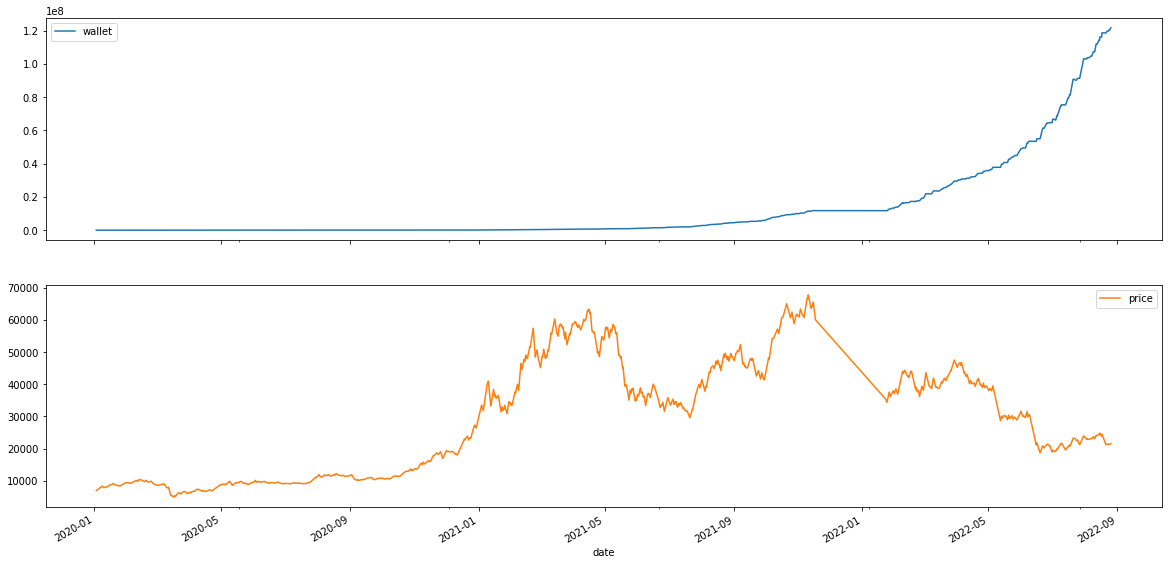

In [12]:
def buyCondition(row:pd.Series, previous_row:pd.Series=None)->bool:
    return True if row.EMA20_diff>0 else False

def sellCondition(row:pd.Series, previous_row:pd.Series=None)->bool:
    return True if row.EMA20_diff<0 else False

strategyTester(df.iloc[1000:],buyCondition,sellCondition,equity=1000)

In [ ]:

df.drop(columns=['EMA20_denoised','EMA20_diff'],inplace=True)

In [32]:
df_final = pd.DataFrame()
for col in df.columns:
    df_final[col]=np.nan

df_final['EMA20_denoised_lowess'] = np.nan
df_final['EMA20_denoised_lowess_diff'] = np.nan
df_final['EMA20_denoised_conv']  = np.nan
df_final['EMA20_denoised_conv_diff'] = np.nan
df_final['EMA20_denoised_hpf']  = np.nan
df_final['EMA20_denoised_hpf_diff']  = np.nan
df_final['EMA20_denoised_savgol']  = np.nan
df_final['EMA20_denoised_savgol_diff'] = np.nan
df_final

,Open,High,Low,Close,Volume,Timestamp,EMA20,EMA20_denoised_lowess,EMA20_denoised_lowess_diff,EMA20_denoised_conv,EMA20_denoised_conv_diff,EMA20_denoised_hpf,EMA20_denoised_hpf_diff,EMA20_denoised_savgol,EMA20_denoised_savgol_diff


In [26]:
from tsmoothie.regression_basis import cubic_spline
from tsmoothie.smoother import ConvolutionSmoother, LowessSmoother, KalmanSmoother, PolynomialSmoother, ExponentialSmoother, WindowWrapper


kucoin_range = 1000

print(f'Before inloop :')
print(df_final)

for i in range(len(df)-kucoin_range):
    df_i = df.iloc[i:i+kucoin_range]
    df_i.dropna(inplace=True)
    df_i['EMA20_denoised_lowess'] = LowessSmoother(smooth_fraction=0.01, iterations=2).smooth(df_i.EMA20.values.reshape(1, -1)).smooth_data.reshape(-1,1)
    df_i['EMA20_denoised_lowess_diff'] = df_i.EMA20_denoised_lowess.diff(1)
    df_i['EMA20_denoised_conv'] = ConvolutionSmoother(50,'bartlett').smooth(df_i.EMA20.values.reshape(1, -1)).smooth_data.reshape(-1,1)
    df_i['EMA20_denoised_conv_diff'] = df_i.EMA20_denoised_conv.diff(1)
    df_i['EMA20_denoised_hpf'] = filterData(df_i.EMA20.values,'savgol')
    df_i['EMA20_denoised_hpf_diff'] = df_i.EMA20_denoised_hpf.diff(1)
    df_i['EMA20_denoised_savgol'] = filterData(df_i.EMA20.values,'hpf')
    df_i['EMA20_denoised_savgol_diff'] = df_i.EMA20_denoised_savgol.diff(1)
    df_final = df_final.append(df_i.iloc[-1],ignore_index=True)
    print(f'{len(df_final)} records')

def buyCondition(row:pd.Series, previous_row:pd.Series=None)->bool:
    return True if row.EMA20_denoised_lowess_diff>0 else False

def sellCondition(row:pd.Series, previous_row:pd.Series=None)->bool:
    return True if row.EMA20_denoised_lowess_diff<0 else False

print(f'Lowess : {strategyTester(df,buyCondition,sellCondition,equity=1000, optimization_process=True)}')

def buyCondition(row:pd.Series, previous_row:pd.Series=None)->bool:
    return True if row.EMA20_denoised_conv_diff>0 else False

def sellCondition(row:pd.Series, previous_row:pd.Series=None)->bool:
    return True if row.EMA20_denoised_conv_diff<0 else False

print(f'Conv : {strategyTester(df,buyCondition,sellCondition,equity=1000, optimization_process=True)}')

def buyCondition(row:pd.Series, previous_row:pd.Series=None)->bool:
    return True if row.EMA20_denoised_hpf_diff>0 else False

def sellCondition(row:pd.Series, previous_row:pd.Series=None)->bool:
    return True if row.EMA20_denoised_hpf_diff<0 else False

print(f'HPF : {strategyTester(df,buyCondition,sellCondition,equity=1000, optimization_process=True)}')

def buyCondition(row:pd.Series, previous_row:pd.Series=None)->bool:
    return True if row.EMA20_denoised_savgol_diff>0 else False

def sellCondition(row:pd.Series, previous_row:pd.Series=None)->bool:
    return True if row.EMA20_denoised_savgol_diff<0 else False

print(f'Savgol : {strategyTester(df,buyCondition,sellCondition,equity=1000, optimization_process=True)}')

Before inloop :
Empty DataFrame
Columns: [Open, High, Low, Close, Volume, Timestamp, EMA20, EMA20_denoised_lowess, EMA20_denoised_lowess_diff, EMA20_denoised_conv, EMA20_denoised_conv_diff, EMA20_denoised_hpf, EMA20_denoised_hpf_diff, EMA20_denoised_savgol, EMA20_denoised_savgol_diff]
Index: []
0 records
In loop
Empty DataFrame
Columns: [Open, High, Low, Close, Volume, Timestamp, EMA20, EMA20_denoised_lowess, EMA20_denoised_lowess_diff, EMA20_denoised_conv, EMA20_denoised_conv_diff, EMA20_denoised_hpf, EMA20_denoised_hpf_diff, EMA20_denoised_savgol, EMA20_denoised_savgol_diff]
Index: []
0 records
In loop
Empty DataFrame
Columns: [Open, High, Low, Close, Volume, Timestamp, EMA20, EMA20_denoised_lowess, EMA20_denoised_lowess_diff, EMA20_denoised_conv, EMA20_denoised_conv_diff, EMA20_denoised_hpf, EMA20_denoised_hpf_diff, EMA20_denoised_savgol, EMA20_denoised_savgol_diff]
Index: []
0 records
In loop
Empty DataFrame
Columns: [Open, High, Low, Close, Volume, Timestamp, EMA20, EMA20_denoised

KeyboardInterrupt: 